In [1]:
import cv2
import numpy as np
import os
import matplotlib.pyplot as plt
import time

In [2]:
def get_image(k):
    name = os.listdir("./images_1")[k]
    
    path = f"./images_1/{name}"
    # Görüntüyü yükleme
    image = cv2.imread(path)
    image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV BGR formatını RGB'ye çevir
    print(image.shape)
    print(image.max())
    print(image.min())
    return image

In [3]:
image = get_image(10)
cv2.imshow("IMAGE",image)
cv2.waitKey(0)

(1080, 1920, 3)
255
0


-1

In [4]:
noise = np.clip(np.random.normal(20,50,image.shape).astype(np.float32),-255,255)
print(noise.max())
print(noise.min())

cv2.imshow("noise",noise.astype(np.uint8))
cv2.waitKey(0)

255.0
-228.72934


-1

In [5]:
noisy = image + noise
print(noisy.max())
print(noisy.min())

cv2.imshow("noisy",noisy.astype(np.uint8))
cv2.waitKey(0)

449.49075
-193.60268


-1

In [9]:
high_mask = np.clip(noisy,255,510) - 255
lower_mask = np.clip(noisy,-255,0)
mixed_mask = high_mask + lower_mask
new_noise = noise - mixed_mask

print(new_noise.max())
print(new_noise.min())

new_noisy = image + new_noise
print(new_noisy.max())
print(new_noisy.min())

cv2.imshow("NEW_NOISY",np.uint8(new_noisy))
cv2.imshow("OLD_NOISY",np.uint8(noisy))
cv2.waitKey(0)


239.00002
-221.83264
255.00002
0.0


-1

In [16]:
backwarded = new_noisy - new_noise
cv2.imshow("BACKWARED",backwarded.astype(np.uint8))
cv2.imshow("ORIG",image.astype(np.uint8))
cv2.waitKey(0)

-1

In [3]:
def add_loud(image,noise_mean=20,noise_std=50):
    noise = np.clip(np.random.normal(20,50,image.shape).astype(np.float32),-255,255)
    noisy = image + noise
    
    high_mask = np.clip(noisy,255,510) - 255
    lower_mask = np.clip(noisy,-255,0)
    mixed_mask = high_mask + lower_mask
    new_noise = noise - mixed_mask
    
    
    new_noisy = image + new_noise
    def _say(im):
        print()
        print(im.dtype)
        print("MAX:",im.max())
        print("MIN:",im.min())

    for i in [noise,noisy,lower_mask,high_mask,mixed_mask,new_noise,new_noisy]:
        _say(i)
    return np.uint8(new_noisy),np.uint8(new_noise)

In [25]:
image = get_image(50)
ny,no = add_loud(image)
backwarded = ny-no

print(backwarded.max())
print(backwarded.min())

cv2.imshow("NOISY",np.uint8(ny))
cv2.imshow("NOISE",np.uint8(no))
cv2.imshow("BACKWARD",np.uint8(backwarded))
cv2.imshow("ORIG",image)
cv2.waitKey(0)

(1080, 1920, 3)
252
0

float32
MAX: 255.0
MIN: -224.2638

float32
MAX: 377.11386
MIN: -191.67166

float32
MAX: 0.0
MIN: -191.67166

float32
MAX: 122.11386
MIN: 0.0

float32
MAX: 122.11386
MIN: -191.67166

float32
MAX: 239.0
MIN: -156.0

float32
MAX: 255.00002
MIN: 0.0
252
0


-1

## GÜRÜLTÜ

In [2]:
#convertions
def add_loud(image,min_mean=-150,max_mean=150,max_sigma=300):
    """
    returns noisy image
    """
    mean = np.random.randint(min_mean,max_mean)
    sigma = np.random.randint(0,max_sigma)
        
    gaussian_noise = np.random.normal(mean, sigma, image.shape).astype(np.float32)
    # Görüntüye gürültü ekleme
    noisy_image = cv2.add(image.astype(np.float32), gaussian_noise)
    noisy_image = np.clip(noisy_image, 0, 255).astype(np.uint8)

    return noisy_image

In [14]:
def add_loud(image,min_mean=-50,max_mean=50,max_sigma=25):
    """
    input:
        image: Image will add a noise
        min_mean: minimum random limit of noise mean
        max_mean: maximum random limit of noise mean
        max_sigma: maximum random limit of max standart deviation [0:max_sigma]
    return:
        noisy_image: image which noise added
        noise_image: image of noise mask
    """
    mean = np.random.randint(min_mean,max_mean)
    sigma = np.random.randint(0,max_sigma)
    
    gaussian_noise = np.random.normal(mean,sigma, image.shape).astype(np.float32)
    
    noisy_im = cv2.add(image.astype(np.float32),gaussian_noise)
    
    higher_mask = np.ones_like(image) * 255 
    higher_map = np.clip(cv2.subtract(noisy_im,higher_mask.astype(np.float32)),0,1500)
    lower_map = np.clip(noisy_im,-1500,0)
    
    absolute_gaussian_noise = cv2.add(higher_map,lower_map)
    
    absolute_noisy_im = cv2.add(image.astype(np.float32),absolute_gaussian_noise)
    return absolute_noisy_im,absolute_gaussian_noise

In [15]:
##test 

names = os.listdir("./images_1")

path = f"./images_1/{names[50]}"
# Görüntüyü yükleme
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV BGR formatını RGB'ye çevir
start = time.time()
noisy_image,noise = add_loud(image)
end = time.time()
print("TİME",end-start)
# Sonucu gösterme
cv2.imshow("Orijinal", cv2.cvtColor(image,cv2.COLOR_BGR2RGB))
cv2.imshow("Noisy Image", cv2.cvtColor(noisy_image,cv2.COLOR_BGR2RGB))
cv2.imshow("Backwarded Image", cv2.cvtColor(cv2.subtract(noisy_image,noise).astype(np.uint8),cv2.COLOR_BGR2RGB))

cv2.waitKey(0)
cv2.destroyAllWindows()

TİME 0.19940686225891113


## BULUT

### tam olmayan bulut eklemek

In [8]:
def add_cloud(image,
              min_opacity=0.4,
              max_opacity=0.7,
              min_cloud_count=1,
              max_cloud_count=2,
              min_cloud_size = 500,
              blur_kernel=(51, 51),
              blur_sigmaX=15,
              brightness_alpha=0, 
              min_brightness_sigma=120,
              max_brightness_sigma=220):
    # 1. Rastgele parlaklık ve saydamlık değerlerini seç
    opacity = np.random.uniform(min_opacity, max_opacity)
    brightness_sigma = np.random.randint(min_brightness_sigma, max_brightness_sigma)

    # 2. Görüntü boyutlarını al
    height, width, _ = image.shape

    def _create_cloud():
        # 3. Bulut boyutlarını rastgele belirle (100x100 ile görüntü boyutları arasında)
    
        cloud_height = np.random.randint(min_cloud_size, height) 
        cloud_width = np.random.randint(min_cloud_size, width)  
    
        # 4. Rastgele bir konum seç
        x_offset = np.random.randint(0, width - cloud_width)
        y_offset = np.random.randint(0, height - cloud_height)
    
        # 5. Boş bir görüntü oluştur ve gürültü ekle
        noise = np.random.normal(0, 1, (cloud_height, cloud_width)).astype(np.float32)
        # 6. Gürültüyü yumuşatarak bulanık yapıya dönüştür
        clouds = cv2.GaussianBlur(noise, blur_kernel, sigmaX=blur_sigmaX)
    
        # 7. Parlaklık seviyesini ve kontrastını ayarla
        clouds = cv2.normalize(clouds, None, alpha=brightness_alpha, beta=brightness_sigma, norm_type=cv2.NORM_MINMAX)
        clouds = clouds.astype(np.uint8)
    
        # 8. Bulutları bulanıklaştırarak yumuşat
        clouds = cv2.GaussianBlur(clouds, (41, 41), sigmaX=10)  # Tamamen bulanıklaştırma
    
        # 9. Kenar opaklığını azaltan bir maske oluştur (kenarlarda daha şeffaflık)
        mask = np.zeros((cloud_height, cloud_width), dtype=np.float32)
        center = (cloud_width // 2, cloud_height // 2)
        radius = min(cloud_width, cloud_height) // 2
        for y in range(cloud_height):
            for x in range(cloud_width):
                distance = np.sqrt((x - center[0]) ** 2 + (y - center[1]) ** 2)
                mask[y, x] = max(0, 1 - distance / radius)  # Kenarlarda şeffaflık artar
    
        # Maskeyi normalize et
        mask = cv2.GaussianBlur(mask, (41, 41), sigmaX=10)
        mask = np.clip(mask, 0, 1)
    
        # Maskeyi bulutlarla birleştir
        clouds = cv2.convertScaleAbs(clouds)
        cloud_rgb = cv2.cvtColor(clouds, cv2.COLOR_GRAY2RGB)
        cloud_rgb = np.uint8(cloud_rgb * mask[..., None])
    
        # 10. Ana görüntü üzerinde bulutların konumlandırılması
        cloud_layer = np.zeros_like(image, dtype=np.uint8)
        cloud_layer[y_offset:y_offset + cloud_height, x_offset:x_offset + cloud_width] = cloud_rgb

        return cloud_layer

    cloud_layers = [ _create_cloud() for i in range(np.random.randint(min_cloud_count,max_cloud_count))]
    # 11. Saydamlık ile görüntüleri birleştir (Genel parlaklık değişmeden, sadece opaklık ile bulut eklenir)
    for layer in cloud_layers:
        image = cv2.addWeighted(image, 1, layer, opacity, 0)

    return cloud_layers, image



time: -0.9231362342834473


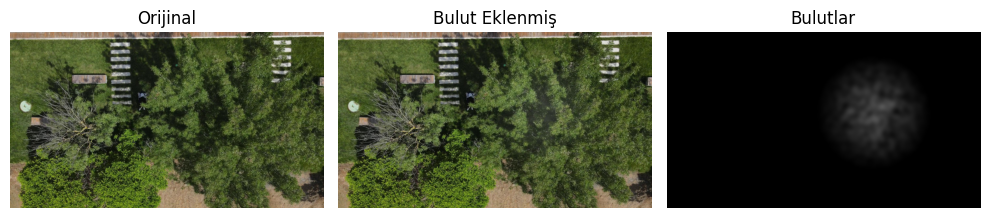

In [9]:
names = os.listdir("./images_1")
path = f"./images_1/{names[200]}"

image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)

start = time.time()
cloud_layers,blended_image = add_cloud(image)
end = time.time()
print("time:",start-end)
# Görüntüleri göster
plt.figure(figsize=(10, 7))

for i in range(len(cloud_layers)+2):
    if i == 0:
        plt.subplot(1, len(cloud_layers)+2, 1); plt.imshow(image); plt.title("Orijinal"); plt.axis("off")
    elif i ==1:
        plt.subplot(1, len(cloud_layers)+2, 2); plt.imshow(blended_image); plt.title("Bulut Eklenmiş"); plt.axis("off")
    else:
        plt.subplot(1, len(cloud_layers)+2, i+1); plt.imshow(cloud_layers[i-2], cmap="gray"); plt.title("Bulutlar"); plt.axis("off")
plt.tight_layout()
plt.show()

## resim bölütleme

In [12]:
def segment_im(im,sub_im_width=1200,sub_im_height=600):
    im_height,im_width,_ = im.shape
    top_left = im[0:sub_im_height,0:sub_im_width]    
    top_right = im[0:sub_im_height,im_width-sub_im_width:im_width]    
    bottom_left = im[im_height-sub_im_height:im_height,0:sub_im_width]    
    bottom_right = im[im_height-sub_im_height:im_height,im_width-sub_im_width:im_width]   

    return top_left,top_right,bottom_left,bottom_right


TİME 0.0


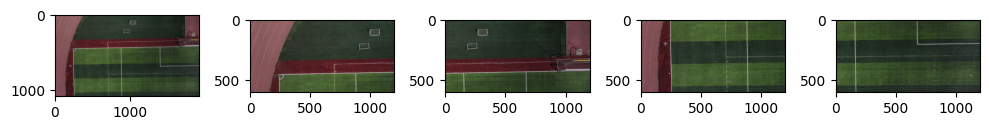

In [15]:
### test

names = os.listdir("./images_1")

path = f"./images_1/{names[0]}"
# Görüntüyü yükleme
image = cv2.imread(path)
image = cv2.cvtColor(image, cv2.COLOR_BGR2RGB)  # OpenCV BGR formatını RGB'ye çevir
start = time.time()
tl,tr,bl,br = segment_im(image)
end = time.time()
print("TİME",end-start)
# Görüntüleri göster
plt.figure(figsize=(10, 7))

imgs = [image,tl,tr,bl,br]
for i in range(len(imgs)):
    plt.subplot(1, 5, i+1); plt.imshow(imgs[i])

plt.tight_layout()
plt.show()

## MATEMATİCAL APPROACHES TO DENOISEING

In [4]:
image =  get_image(1)

(1080, 1920, 3)
253
0


In [5]:
noisy,noise = add_loud(image)


float32
MAX: 255.0
MIN: -255.0

float32
MAX: 421.2063
MIN: -215.0

float32
MAX: 0.0
MIN: -215.0

float32
MAX: 166.2063
MIN: 0.0

float32
MAX: 166.2063
MIN: -215.0

float32
MAX: 237.0
MIN: -179.32927

float32
MAX: 255.00002
MIN: 0.0


In [ ]:
dst = cv2.fastNlMeansDenoisingColored(noisy, None, 20, 20, 9, 39)

cv2.imshow("Denoised", dst)
cv2.imshow("Noisy",noisy)
cv2.waitKey(0)
cv2.destroyAllWindows()


In [6]:
import numpy as np
img = noisy.copy()
gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
dft = cv2.dft(np.float32(gray), flags=cv2.DFT_COMPLEX_OUTPUT)
dft_shift = np.fft.fftshift(dft)

# Orta kısımdaki düşük frekanslı bileşenleri koruyarak gürültüyü azalt
rows, cols = gray.shape
crow, ccol = rows//2, cols//2
mask = np.zeros((rows, cols, 2), np.uint8)
mask[crow-30:crow+30, ccol-30:ccol+30] = 1

fshift = dft_shift * mask
f_ishift = np.fft.ifftshift(fshift)
img_back = cv2.idft(f_ishift)
img_back = cv2.magnitude(img_back[:,:,0], img_back[:,:,1])

cv2.imshow("Noisy",noisy)
cv2.imshow("Filtered Image", img_back)
cv2.waitKey(0)
cv2.destroyAllWindows()
